In [65]:
import numpy as np
import pandas as pd
import re
import warnings

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import cross_val_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pickle

In [66]:
warnings.filterwarnings(action="ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 1.0. Data Reading and Cleaning

In [67]:
dataset = './data/tabela-fipe-historico-precos.csv'
df_raw = pd.read_csv(dataset)

In [68]:
df_raw.head()

,Unnamed: 0,codigoFipe,marca,modelo,anoModelo,mesReferencia,anoReferencia,valor
0,0,038003-2,Acura,Integra GS 1.8,1992,11,2016,13041.0
1,1,038001-6,Acura,NSX 3.0,1995,3,2013,52339.0
2,2,038003-2,Acura,Integra GS 1.8,1992,3,2018,12423.0
3,3,038002-4,Acura,Legend 3.2/3.5,1998,5,2016,31067.0
4,4,038002-4,Acura,Legend 3.2/3.5,1998,2,2019,26381.0


In [69]:
df_raw.shape

(466020, 8)

In [70]:
df_raw.columns

Index(['Unnamed: 0', 'codigoFipe', 'marca', 'modelo', 'anoModelo',
       'mesReferencia', 'anoReferencia', 'valor'],
      dtype='object')

In [71]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466020 entries, 0 to 466019
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     466020 non-null  int64  
 1   codigoFipe     466020 non-null  object 
 2   marca          466020 non-null  object 
 3   modelo         466020 non-null  object 
 4   anoModelo      466020 non-null  int64  
 5   mesReferencia  466020 non-null  int64  
 6   anoReferencia  466020 non-null  int64  
 7   valor          466020 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 28.4+ MB


<Axes: ylabel='Frequency'>

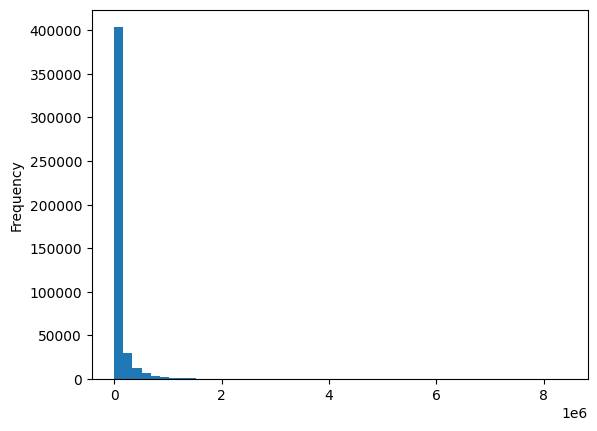

In [72]:
df_raw['valor'].plot(kind='hist', bins = 50)

## 1.1. Data Cleaning

In [73]:
df1 = df_raw.copy()
df1.shape

(466020, 8)

In [74]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466020 entries, 0 to 466019
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     466020 non-null  int64  
 1   codigoFipe     466020 non-null  object 
 2   marca          466020 non-null  object 
 3   modelo         466020 non-null  object 
 4   anoModelo      466020 non-null  int64  
 5   mesReferencia  466020 non-null  int64  
 6   anoReferencia  466020 non-null  int64  
 7   valor          466020 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 28.4+ MB


In [75]:
def snake_case(c):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', c).lower()
df1.columns = [snake_case(c) for c in df1.columns]

categorical_columns = list(df1.dtypes[df1.dtypes == 'object'].index)
for c in categorical_columns:
    df1[c] = df1[c].str.lower().str.replace(' ', '_')
    df1[c] = df1[c].str.replace('-','_')

df1['codigo_fipe'] = df1['codigo_fipe'].str.replace('-','')

In [76]:
# couldn't figure out how to not import this column while reading the dataset
df1.drop(columns=['unnamed: 0'], inplace=True)

### 1.1.1. Checking Data Types

In [77]:
df1.dtypes

codigo_fipe        object
marca              object
modelo             object
ano_modelo          int64
mes_referencia      int64
ano_referencia      int64
valor             float64
dtype: object

In [78]:
df1['codigo_fipe'] = df1['codigo_fipe'].astype('int64')

In [79]:
df1.dtypes

codigo_fipe         int64
marca              object
modelo             object
ano_modelo          int64
mes_referencia      int64
ano_referencia      int64
valor             float64
dtype: object

### 1.1.2. Checking for Missing Values

In [80]:
df1.isna().sum()

codigo_fipe       0
marca             0
modelo            0
ano_modelo        0
mes_referencia    0
ano_referencia    0
valor             0
dtype: int64

### 1.1.3. Checking for Duplicated Values

In [81]:
df1.duplicated().sum()

0

# 2.0. Feature Engineering

In [82]:
df2 = df1.copy()

In [83]:
media_por_marca = df2.groupby('marca')['valor'].mean()

df2['classificacao_marca'] = df2['marca'].map(
        lambda marca: (
        'economical' if media_por_marca[marca] <= 50_000 else
        'affordable' if media_por_marca[marca] <= 100_000 else
        'mid_range' if media_por_marca[marca] <= 500_000 else
        'luxury' if media_por_marca[marca] <= 1_000_000 else
        'super_luxury'
    )
)

In [84]:
df2['classificacao_modelo'] = df2['valor'].map(lambda x: (
    1 if x <= 50_000 else
    2 if x <= 100_000 else
    3 if x <= 500_000 else
    4 if x <= 1_000_000 else
    5 if x <= 5_000_000 else
    6
))

# 3.0. Feature Selection

In [85]:
df3 = df2.copy()
df3.drop(columns=['modelo'], inplace=True)

In [86]:
df3.columns

Index(['codigo_fipe', 'marca', 'ano_modelo', 'mes_referencia',
       'ano_referencia', 'valor', 'classificacao_marca',
       'classificacao_modelo'],
      dtype='object')

# 4.0 Spliting Data

In [87]:
df4 = df3.copy()
df_full_train, df_test = train_test_split(df4, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

y_train = X_train.valor.values
y_val = X_val.valor.values
y_test = X_test.valor.values

X_train.drop(columns=['valor'], inplace=True)
X_val.drop(columns=['valor'], inplace=True)
X_test.drop(columns=['valor'], inplace=True)

## 4.1. Transformation & Scaling

In [88]:
# logarithmic transformation
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

# scaling of numerical features
numerical_cols = ['codigo_fipe', 'ano_modelo', 'classificacao_modelo', 'ano_referencia', 'mes_referencia']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

## 4.2. Encoding

In [89]:
# OHE to 'classificacao_marca'
X_train = pd.get_dummies(X_train, columns=['classificacao_marca'], drop_first=False)
X_val = pd.get_dummies(X_val, columns=['classificacao_marca'], drop_first=False)
X_test = pd.get_dummies(X_test, columns=['classificacao_marca'], drop_first=False)

# Embedding Layers to 'marca'
label_encoder = LabelEncoder()
X_train['marca_encoded'] = label_encoder.fit_transform(X_train['marca'])
X_val['marca_encoded'] = label_encoder.transform(X_val['marca'])
X_test['marca_encoded'] = label_encoder.transform(X_test['marca'])

num_categories = len(label_encoder.classes_)
embedding_dim = 10 
embedding_layer = nn.Embedding(num_categories, embedding_dim)

marca_indices = torch.tensor([0, 1, 2])
marca_embeddings = embedding_layer(marca_indices)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train_log.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val_log.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test_log.shape}")

X_train shape: (279612, 12), y_train shape: (279612,)
X_val shape: (93204, 12), y_val shape: (93204,)
X_test shape: (93204, 12), y_test shape: (93204,)


In [90]:
X_train_tensor = torch.tensor(X_train.drop(columns=['marca', 'marca_encoded']).astype('float32').values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.drop(columns=['marca', 'marca_encoded']).astype('float32').values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.drop(columns=['marca', 'marca_encoded']).astype('float32').values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_log, dtype=torch.float32).view(-1, 1)

X_train_cat = torch.tensor(X_train['marca_encoded'].values, dtype=torch.long)
X_val_cat = torch.tensor(X_val['marca_encoded'].values, dtype=torch.long)
X_test_cat = torch.tensor(X_test['marca_encoded'].values, dtype=torch.long)

# 5.0. Training Neural Network

In [91]:
class NeuralNetwork(nn.Module):
    def __init__(self, embedding_dim, num_categories, input_dim, hidden_dim=64):
        super(NeuralNetwork, self).__init__()
        
        self.embedding = nn.Embedding(num_categories, embedding_dim)
        self.fc1 = nn.Linear(input_dim + embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x_numeric, x_categorical):
        x_embedded = self.embedding(x_categorical)
        
        # verify shape
        print(f"Numeric Input Shape: {x_numeric.shape}")
        print(f"Categorical Embedding Shape: {x_embedded.shape}")
        
        x = torch.cat((x_numeric, x_embedded), dim=1)
        
        # confirm dimension
        print(f"Concatenated Input Shape: {x.shape}")
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

embedding_dim = 10
num_categories = len(label_encoder.classes_)
input_dim = X_train_tensor.shape[1]

model = NeuralNetwork(embedding_dim, num_categories, input_dim)


In [92]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [93]:
def train_model(model, X_train_tensor, X_train_cat, y_train_tensor, epochs=50, batch_size=32):
    model.train()
    for epoch in range(epochs):
        perm = torch.randperm(X_train_tensor.size(0))
        
        for i in range(0, X_train_tensor.size(0), batch_size):
            batch_idx = perm[i:i+batch_size]
            X_batch_numeric = X_train_tensor[batch_idx]
            X_batch_cat = X_train_cat[batch_idx]
            y_batch = y_train_tensor[batch_idx]
            
            optimizer.zero_grad()
            
            y_pred = model(X_batch_numeric, X_batch_cat)
            
            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss:{loss.item()}')

In [94]:
def evaluate_model(model, x_numeric, x_categorical, y_true_log):
    model.eval()
    with torch.no_grad():
        y_pred_log = model(x_numeric, x_categorical).squeeze(1).numpy()
        y_true_original = np.expm1(y_true_log.squeeze().numpy())
        
        print(f"y_pred_log shape: {y_pred_log.shape}")
        print(f"y_true_original shape: {y_true_original.shape}")
        assert y_pred_log.shape == y_true_original.shape, \
            f"Dimensões incompatíveis: y_pred_log={y_pred_log.shape}, y_true_original={y_true_original.shape}"
        
        y_pred_original = np.expm1(y_pred_log)
        
        rmse = np.sqrt(np.mean((y_true_original - y_pred_original) ** 2))
        print(f"Validation RMSE: {rmse}")
        
        return y_pred_original, rmse


In [95]:
evaluate_model(model, X_val_tensor, X_val_cat, y_val_tensor)

Numeric Input Shape: torch.Size([93204, 10])
Categorical Embedding Shape: torch.Size([93204, 10])
Concatenated Input Shape: torch.Size([93204, 20])
y_pred_log shape: (93204,)
y_true_original shape: (93204,)
Validation RMSE: 344206.78125


(array([ 0.07533637,  0.09524595, -0.03020955, ...,  0.18097398,
        -0.01794663,  0.10588169], dtype=float32),
 344206.78)

In [96]:
evaluate_model(model, X_test_tensor, X_test_cat, y_test_tensor)

Numeric Input Shape: torch.Size([93204, 10])
Categorical Embedding Shape: torch.Size([93204, 10])
Concatenated Input Shape: torch.Size([93204, 20])
y_pred_log shape: (93204,)
y_true_original shape: (93204,)
Validation RMSE: 349783.6875


(array([ 0.0559428 , -0.04806855,  0.07359068, ..., -0.00763141,
         0.07520441,  0.02188597], dtype=float32),
 349783.7)